# **Experiment 1**: **Image /Video Reading and Display**
Develop a Python program using OpenCV to demonstrate image acquisition and video acquisition
by reading images in multiple modes and capturing live video from a camera, displaying and storing
the video stream.

--- IMAGE ---
1. Color Image:


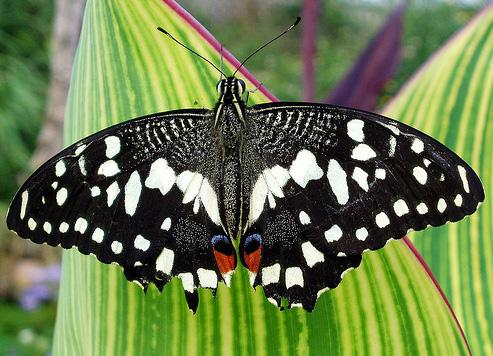

2. Grayscale Image:


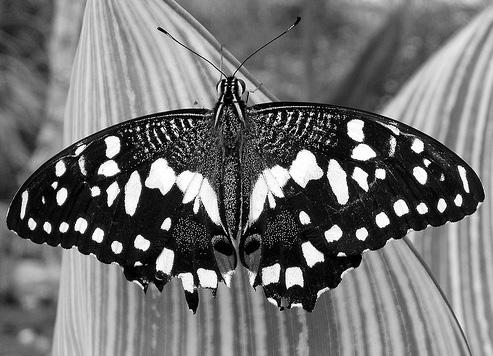


--- WebCam VIDEO ---


<IPython.core.display.Javascript object>

Video recording and conversion complete.

--- DISPLAY ---
RGB Video:


Grayscale Video:


In [5]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode

# ==========================================
# IMAGE ACQUISITION
# ==========================================
print("--- IMAGE ---")
# Download a sample image
!wget -q -O input_sample.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/butterfly.jpg

# Read in different modes
img_color = cv2.imread('input_sample.jpg', cv2.IMREAD_COLOR)      # BGR
img_gray = cv2.imread('input_sample.jpg', cv2.IMREAD_GRAYSCALE)  # Grayscale
img_unchanged = cv2.imread('input_sample.jpg', cv2.IMREAD_UNCHANGED)


print("1. Color Image:")
cv2_imshow(img_color)

print("2. Grayscale Image:")
cv2_imshow(img_gray)


# ==========================================
# VIDEO ACQUISITION
# ==========================================
print("\n--- WebCam VIDEO ---")

def record_video_js(seconds=5):
    js = Javascript('''
        async function recordVideo(seconds) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const ctx = canvas.getContext('2d');

            const frames = [];
            const endTime = Date.now() + (seconds * 1000);

            while (Date.now() < endTime) {
                ctx.drawImage(video, 0, 0);
                frames.push(canvas.toDataURL('image/jpeg', 0.5));
                await new Promise(r => setTimeout(r, 100)); // ~10 fps
            }

            stream.getVideoTracks()[0].stop();
            div.remove();
            return frames;
        }
    ''')
    display(js)
    return eval_js(f'recordVideo({seconds})')

try:
    # 1. Capture frames from browser
    raw_frames = record_video_js(seconds=5)

    # 2. Setup VideoWriters
    first_frame_bytes = b64decode(raw_frames[0].split(',')[1])
    first_frame = cv2.imdecode(np.frombuffer(first_frame_bytes, np.uint8), -1)
    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    out_rgb = cv2.VideoWriter('output_rgb.avi', fourcc, 10.0, (w, h))
    out_gray = cv2.VideoWriter('output_gray.avi', fourcc, 10.0, (w, h), isColor=False)

    # 3. Process and Save Frames
    for frame_data in raw_frames:
        img_bytes = b64decode(frame_data.split(',')[1])
        frame_bgr = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)

        # Grayscale Conversion
        frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        out_rgb.write(frame_bgr)
        out_gray.write(frame_gray)

    out_rgb.release()
    out_gray.release()
    print("Video recording and conversion complete.")

except Exception as e:
    print(f"Error: {e}")

# ==========================================
# DISPLAY
# ==========================================
print("\n--- DISPLAY ---")

# Convert to MP4 for browser compatibility
!ffmpeg -i output_rgb.avi -vcodec libx264 -f mp4 rgb_final.mp4 -y -loglevel quiet
!ffmpeg -i output_gray.avi -vcodec libx264 -f mp4 gray_final.mp4 -y -loglevel quiet

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

print("RGB Video:")
display(show_video('rgb_final.mp4'))

print("Grayscale Video:")
display(show_video('gray_final.mp4'))